In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import skimage.transform as transform
import cv2 as cv

In [125]:
def expert_preprocess(full_filepath, is_img=True):
    img_npz = np.load(full_filepath)
    if is_img:
        img = img_npz["imgs"] # (2487, 2048, 3)
    else:
        img = img_npz["gts"]
    img_1024 = transform.resize(
                img, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
            ).astype(np.uint8)
    if is_img:
        lower_bound, upper_bound = np.percentile(img_1024[img_1024 > 0], 0.5), np.percentile(img_1024[img_1024 > 0], 99.5)
        img_1024_pre = np.clip(img_1024, lower_bound, upper_bound)
        img_1024_pre = (img_1024_pre - np.min(img_1024_pre)) / (np.max(img_1024_pre) - np.min(img_1024_pre)) * 255.0
        img_1024_pre[img_1024 == 0] = 0
        img_1024_pre = img_1024_pre.astype(np.uint8)
        return img_1024_pre
    return img_1024

def get_visualizable_mask(mask):
    rgba = np.zeros((*mask.shape, 4), dtype=float)
    rgba[..., 0] = 0  # Red channel
    rgba[..., 1] = 1  # Green channel
    rgba[..., 2] = 0  # Blue channel
    rgba[..., 3] = (mask > 0).astype(float) * 0.7  # Alpha channel
    return rgba

def agent_preprocess(full_filepath, is_img=True):
    img_npz = np.load(full_filepath)
    # print("Full filepath", full_filepath)
    if is_img:
        img = img_npz["imgs"] # (2487, 2048, 3)
    else:
        img = img_npz["gts"]
    # print("shape before resize", img.shape)
    img_1024 = transform.resize(
                img, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
            ).astype(np.uint8)
    # print('after resize', img_1024.shape)
    if is_img:
        img_1024 = np.copy(img_1024)
        img_1024 = img_1024.astype(np.float32)
        if img_1024.max() > 1.5:
            img_1024 = img_1024 / 255.0
        img_1024_uint8 = (img_1024 * 255).astype(np.uint8)
        if img_1024_uint8.shape[2] == 3:
            gray = cv.cvtColor(img_1024_uint8, cv.COLOR_BGR2GRAY)
            eq = cv.equalizeHist(gray)
            eq_color = cv.cvtColor(eq, cv.COLOR_GRAY2BGR)
            processed_img_1024 = eq_color.astype(np.float32) / 255.0
        else:
            eq = cv.equalizeHist(img_1024_uint8.squeeze())
            eq_exp = np.expand_dims(eq, axis=-1)
            processed_img_1024 = eq_exp.astype(np.float32) / 255.0
        return processed_img_1024   
    return img_1024

In [128]:
def entire_pipeline(filename):
    img_filepath = os.path.join(os.getcwd(), f"../data/imgs/{filename}")
    mask_filepath = os.path.join(os.getcwd(), f"../data/gts/{filename}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # left image - expert
    expert_processed_img = expert_preprocess(img_filepath, is_img=True)
    expert_processed_mask = expert_preprocess(mask_filepath, is_img=False)
    expert_good_mask = get_visualizable_mask(expert_processed_mask)
    axes[0].imshow(expert_processed_img)
    axes[0].imshow(expert_good_mask)
    axes[0].set_title("Expert")

    # right image - agent
    agent_processed_img = agent_preprocess(img_filepath, is_img=True)
    agent_processed_mask = agent_preprocess(mask_filepath, is_img=False)
    agent_good_mask = get_visualizable_mask(agent_processed_mask)
    axes[1].imshow(agent_processed_img)
    axes[1].imshow(agent_good_mask)
    axes[1].set_title("Agent")

    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

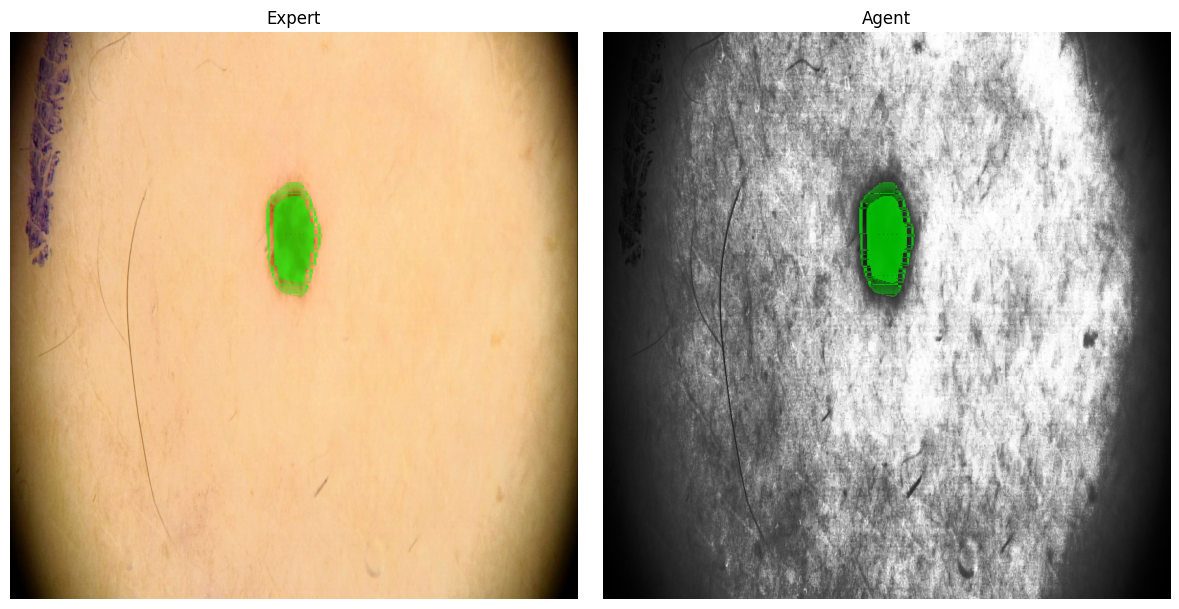

In [129]:
entire_pipeline(filename="2DBox_Dermoscopy_0051.npz")

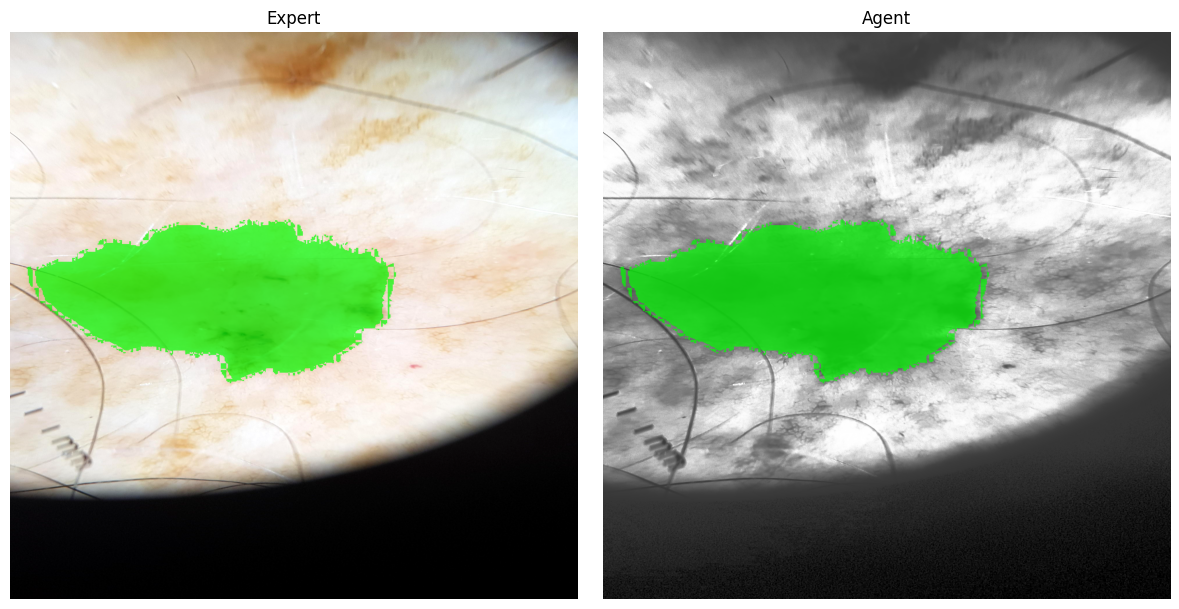

In [130]:
entire_pipeline(filename="2DBox_Dermoscopy_0060.npz")